# NST
Generando imágenes con distintos niveles de detalle en el estilo. En concreto se usan los 5 niveles "clásicos" de menos profundidad a mas profundidad. Los niveles se van acumulando. Además se normalizan los pesos del estilo y del contenido para que sean selecionables.

In [1]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

import tensorflow as tf

In [2]:

content_image = PIL.Image.open('valencia.png')
style_image = PIL.Image.open('oxford.png')

#content_image = PIL.Image.open('content_image.png')
#style_image = PIL.Image.open('style_image.png')

Imsize = 200

In [3]:
content_image = np.asarray(content_image.resize((Imsize,Imsize)))
style_image = np.asarray(style_image.resize((Imsize,Imsize)))

In [4]:
content_image = content_image[:,:,0:3].astype(np.float32)/255
style_image = style_image[:,:,0:3].astype(np.float32)/255

style_image.shape

(200, 200, 3)

In [5]:
content_image = np.expand_dims(content_image,0)
style_image = np.expand_dims(style_image,0)
content_image.shape

(1, 200, 200, 3)

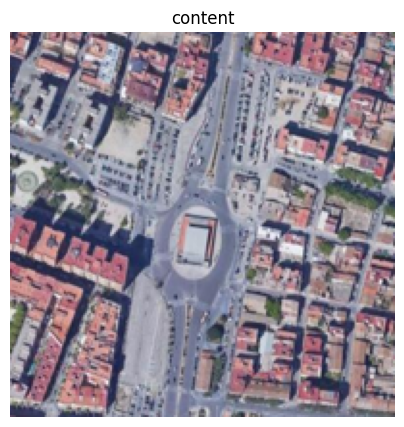

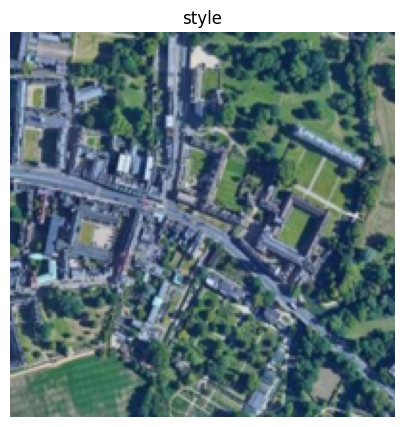

In [8]:
plt.figure(figsize=(5,5))
plt.imshow(content_image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.title('content')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(style_image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.title('style')
plt.show()

## Construir modelo

### Construye el modelo

In [9]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model


In [10]:
#vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
#vgg.summary()

### Calcular estilo

In [11]:
def gram_matrix(input_tensor):
    # Con la media por canal
    result = tf.math.reduce_mean(input_tensor, [1,2])
    #input_shape = tf.shape(input_tensor)
    #num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result#/(num_locations)


### Extraer estilo y contenido

In [12]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


### función de pérdidas

In [13]:
def style_content_loss(outputs,style_weight,content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    #style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
    #                       for name in style_outputs.keys()])
    #style_loss *= style_weight

    style_loss = [style_weight*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()]

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight
    loss = style_loss + content_loss

    return loss, style_loss, content_loss


In [14]:
def clip_0_1(image):
      return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# BUCLE

In [15]:
import timeit


In [43]:
opt = tf.optimizers.Adam(learning_rate=0.005, beta_1=0.99, epsilon=1e-1)

In [44]:
style_layers_ori = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

content_layers = ['block5_conv2']

In [45]:
STYLE_WEIGHT = 10000
CONTENT_WEIGHT = 0.5
Nepochs = 100000
muestra_cada = 200

Testing the statistics size

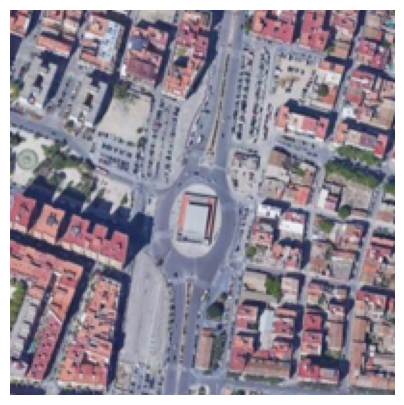

1.4985098e-08 1.4985098e-08 0.0
0.28684404 0.0 0.28684404
10000.0 10000.0 0.0
0.49999997 0.0 0.49999997
0 9767.094 9767.094 2.3146515e-05
Time:  0.5583978720000005
200 453.08374 452.94174 0.1420033
Time:  0.7964735130000236
400 9.89838 9.739402 0.15897809
Time:  1.1323116410000011
600 11.8843155 11.715261 0.16905376
Time:  1.458526237000001
800 0.77255386 0.6018084 0.17074542
Time:  1.8175981780000257
1000 0.59547025 0.4240436 0.17142664
Time:  2.1765804840000555
1200 0.33129805 0.15967494 0.1716231
Time:  2.535135094999987
1400 0.26366615 0.09202863 0.17163752
Time:  2.858289746999958
1600 0.23699856 0.06515343 0.17184512
Time:  3.225456235000024
1800 0.22121279 0.049198657 0.17201413
Time:  3.6166631730000063
2000 0.21052137 0.03841708 0.17210428
Time:  3.9530344099999866
2200 0.2028176 0.0306315 0.1721861
Time:  4.302129852999997
2400 0.19699085 0.024717744 0.1722731
Time:  4.612971834000064
2600 0.192496 0.020145161 0.17235084
Time:  4.955065555000033
2800 0.18897377 0.016575065 0.

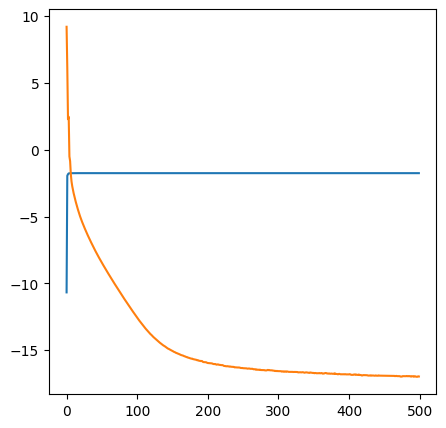

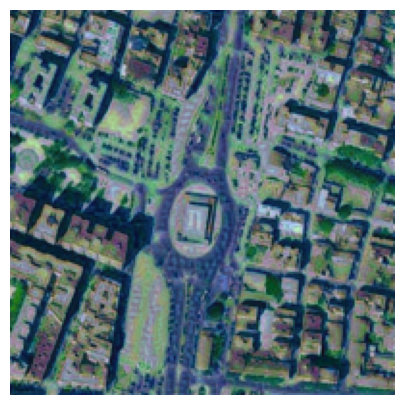

style_weight: 33.36648269538091 content_weight: 0.00017431074789537834
['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


In [46]:


style_layers = style_layers_ori[0:5]#layer]

extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

#image = tf.Variable(content_image.copy())
image = tf.Variable(content_image.copy())

plt.figure(figsize=(5,5))
plt.imshow(image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.show()


# WEIGHTS FIRST GUESS
style_weight_FG=5*1e-11
content_weight_FG=1e-4

loss, style_loss, content_loss = style_content_loss(extractor(content_image),style_weight_FG,content_weight_FG)
print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))
loss_style = np.array(style_loss[0])

loss, style_loss, content_loss = style_content_loss(extractor(style_image),style_weight_FG,content_weight_FG)
print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))
loss_content = np.array(content_loss)

# WEIGTHS DEFINITION
style_weight= style_weight_FG * STYLE_WEIGHT/loss_style
content_weight= content_weight_FG * CONTENT_WEIGHT/loss_content

# Certify Weights
loss, style_loss, content_loss = style_content_loss(extractor(content_image),style_weight,content_weight)
print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))

loss, style_loss, content_loss = style_content_loss(extractor(style_image),style_weight,content_weight)
print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))

@tf.function()  # Precompile
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs,style_weight,content_weight)

    grad = tape.gradient(loss[1][0], image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

L_cont = np.array([])
L_style = np.array([])

start = timeit.default_timer()
for n in range(0,Nepochs):
    train_step(image)

    if np.mod(n,muestra_cada)==0:
        outputs = extractor(image)
        loss, style_loss, content_loss = style_content_loss(outputs,style_weight,content_weight)

        L_cont = np.append(L_cont,np.array(content_loss))
        L_style = np.append(L_style,np.array(style_loss[0]))

        print(n, np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))

        stop = timeit.default_timer()
        print('Time: ', stop - start)

# RESULTS
# Curvas
plt.figure(figsize=(5,5))
plt.plot(np.log(L_cont))
plt.plot(np.log(L_style))
plt.show()

# Resultados
plt.figure(figsize=(5,5))
plt.imshow(image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.show()

# Keep track
print('style_weight: ' + str(style_weight) + ' content_weight: ' + str(content_weight))
print(style_layers)

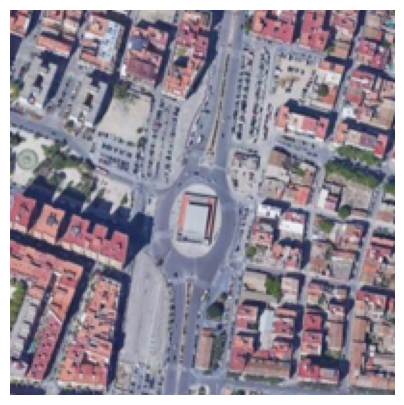

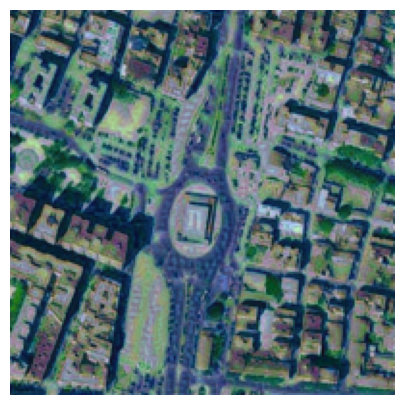

In [47]:
plt.figure(figsize=(5,5))
plt.imshow(content_image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.show()

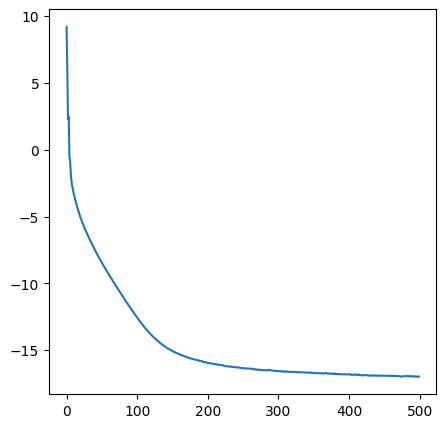

In [48]:
    # Curvas
    plt.figure(figsize=(5,5))
    #plt.plot(np.log(L_cont[20:]))
    plt.plot(np.log(L_style[0:]))
    plt.show()